In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import cv2
import caffe

In [2]:
image = cv2.imread('../data/images/a_abbey_abbey_000001.jpg')

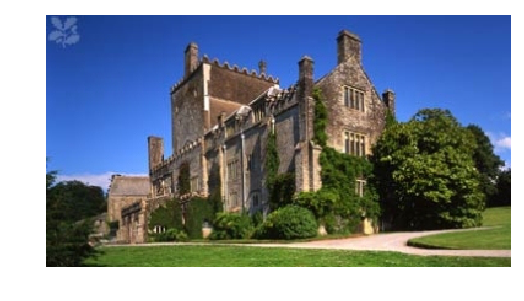

In [3]:
plt.axis('off')
plt.imshow(image[:, :, (2, 1, 0)])

In [4]:
from imret.preprocess import Segment

In [5]:
net = Segment('/Users/danilonunes/Downloads/20170527-222129-0246_epoch_11.0/deploy.prototxt', 
              '/Users/danilonunes/Downloads/20170527-222129-0246_epoch_11.0/snapshot_iter_5412.caffemodel',
              '../data/query/name_conversion.csv', gpu=False)

Creating net with: 
/Users/danilonunes/Downloads/20170527-222129-0246_epoch_11.0/deploy.prototxt 
/Users/danilonunes/Downloads/20170527-222129-0246_epoch_11.0/snapshot_iter_5412.caffemodel


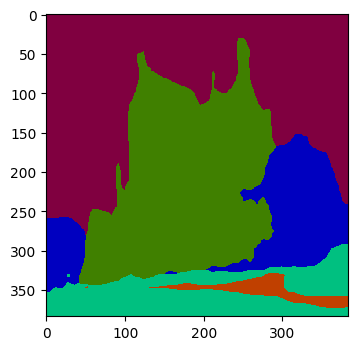

In [95]:
palette = net.segmentation(image)
plt.imshow(palette)

In [98]:
weighted = net.weighted_image(image)

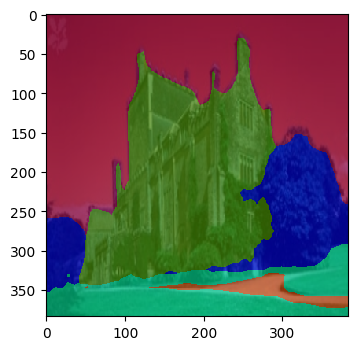

In [100]:
plt.imshow(weighted[:, :, (2, 1, 0)])

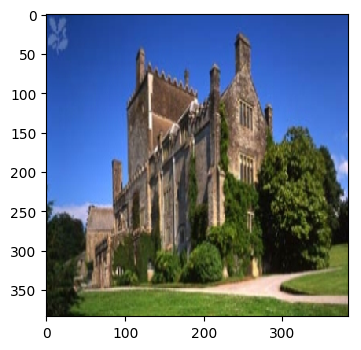

In [102]:
rsz = scipy.misc.imresize(image, (384, 384))
plt.imshow(rsz[:, :, (2, 1, 0)])

In [106]:
cv2.imwrite('/Users/danilonunes/Dropbox/Latex/Thesis-final/mainmatter/data/method/test.jpg', rsz)
cv2.imwrite('/Users/danilonunes/Dropbox/Latex/Thesis-final/mainmatter/data/method/segmented.png', palette[:, :, (2, 1, 0)])
cv2.imwrite('/Users/danilonunes/Dropbox/Latex/Thesis-final/mainmatter/data/method/weighted.png', weighted)

True

CPU times: user 9.51 s, sys: 453 ms, total: 9.96 s
Wall time: 2.51 s


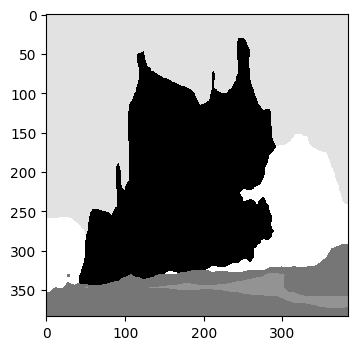

In [60]:
%time segmented = net.segmentation(image, return_paletted=False)
plt.imshow(segmented, cmap='gray')

In [17]:
def create_mask(image, pixel_value, color):
    w, h = image.shape
    m1 = np.zeros((w, h), dtype=image.dtype)
    m2 = np.zeros((w, h, 3), dtype=image.dtype)

    x, y = np.where(image == pixel_value)
    m1[x, y] = 1
    m2[x, y, :] = color
    return m1, m2

In [62]:
import itertools
import scipy.misc

alpha = 0.4
images = []
image_ = scipy.misc.imresize(image, segmented.shape, interp='bilinear')

for (x1, x2) in itertools.permutations(np.unique(segmented), 2):
    mask1, overlay1 = create_mask(segmented, x1, color=(255, 0, 0))
    mask2, overlay2 = create_mask(segmented, x2, color=(0, 0, 255))
    
    img1 = cv2.bitwise_and(image_, image_, mask=mask1.astype(image_.dtype))
    img2 = cv2.bitwise_and(image_, image_, mask=mask2.astype(image_.dtype))
    img = cv2.bitwise_or(img1, img2)
    cv2.addWeighted(overlay1.astype(np.uint8), alpha, img, 1 - alpha, 0, img)
    cv2.addWeighted(overlay2.astype(np.uint8), alpha, img, 1 - alpha, 0, img)
    images.append((img, (x1, x2)))

In [108]:
print len(list(itertools.permutations(np.unique(segmented), 2)))

20


In [114]:
def vis_square(data):
    """Take an array of shape (n, height, width) or (n, height, width, 3)
       and visualize each (height, width) thing in a grid of size approx. sqrt(n) by sqrt(n)"""
    
    # normalize data for display
#     data = (data - data.min()) / (data.max() - data.min())
    
    # force the number of filters to be square
    n = int(np.ceil(np.sqrt(data.shape[0])))
    padding = (((0, n ** 2 - data.shape[0]),
               (0, 1), (0, 1))                 # add some space between filters
               + ((0, 0),) * (data.ndim - 3))  # don't pad the last dimension (if there is one)
    data = np.pad(data, padding, mode='constant', constant_values=1)  # pad with ones (white)
    
    # tile the filters into an image
    data = data.reshape((n, n) + data.shape[1:]).transpose((0, 2, 1, 3) + tuple(range(4, data.ndim + 1)))
    data = data.reshape((n * data.shape[1], n * data.shape[3]) + data.shape[4:])
    return data

In [146]:
np.pad?

In [161]:
output = np.array([img for (img, _) in images])
n = int(np.ceil(np.sqrt(output.shape[0])))
print n
padding = (((0, n ** 2 - output.shape[0]),  
            (0, 1), (0, 1))                 # add some space between filters
            + ((0, 0),) * (output.ndim - 3))
data = np.pad(output, padding, mode='constant', constant_values=255)
print data.shape, data.ndim
data = data.reshape((n, n) + data.shape[1:]).transpose((0, 2, 1, 3) + tuple(range(4, data.ndim + 1)))
print data.shape
data = data.reshape((n * data.shape[1], n * data.shape[3]) + data.shape[4:])
print data.shape

5
(25, 385, 385, 3) 4
(5, 385, 5, 385, 3)
(1925, 1925, 3)


In [157]:
4 * 385, 4 * 385

(1540, 1540)

True

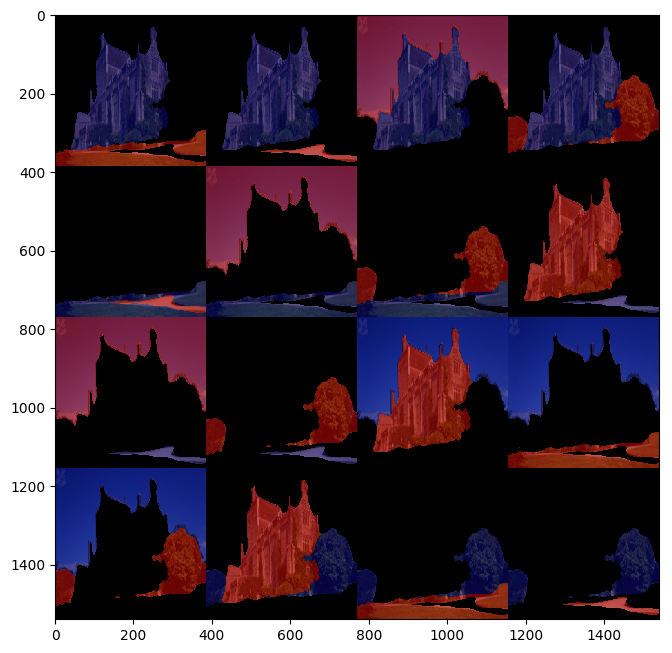

In [162]:
plt.figure(figsize=(12, 8))
plt.imshow(data[:1540, :1540, (2, 1, 0)])
cv2.imwrite("pairs.png", data[:1540, :1540, :])

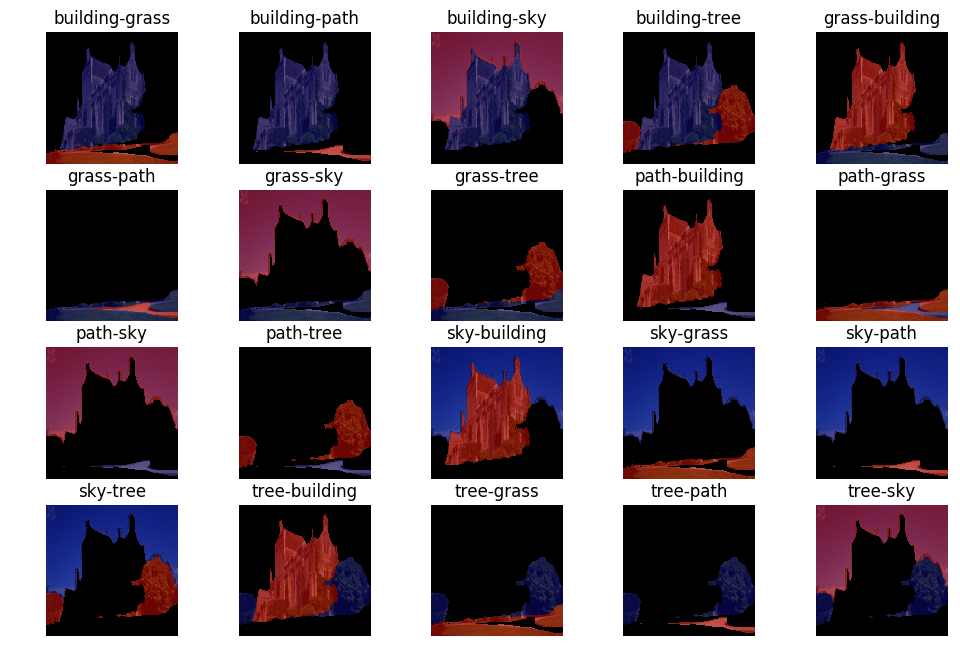

In [110]:
plt.figure(figsize=(12, 8))
for idx, (img, (n1, n2)) in enumerate(images):
    plt.subplot(4, 5, idx + 1)
    plt.axis('off')
    plt.title("{}-{}".format(net.color_palette.get_name(n1),
                             net.color_palette.get_name(n2)))
    plt.imshow(img[:, :, (2, 1, 0)])

In [39]:
prep_net = caffe.Net('../data/models/preposition/deploy.prototxt',
                     '../data/models/preposition/snapshot.caffemodel',
                     caffe.TEST)

In [64]:
with open('../data/models/preposition/mean.binaryproto', 'rb') as f:
    blob = caffe.proto.caffe_pb2.BlobProto()
    blob.MergeFromString(f.read())
    mean_image = np.reshape(blob.data, (3, 256, 256))
    data_shape = tuple((1, 3, 227, 227))
    assert len(data_shape) == 4, 'Bad data shape.'
    mean_image = mean_image.astype(np.uint8)
    mean_image = mean_image.transpose(1, 2, 0)
    shape = list(mean_image.shape)
    mean_image = scipy.misc.imresize(mean_image, (data_shape[2], data_shape[3]))
    mean_image = mean_image.transpose(2, 0, 1)
    mean_image = mean_image.astype('float')
        
transformer = caffe.io.Transformer({'data': prep_net.blobs['data'].data.shape})
transformer.set_transpose('data', (2, 0, 1))
transformer.set_channel_swap('data', (2, 1, 0))
transformer.set_mean('data', mean_image)

In [65]:
_, channels, w, h = prep_net.blobs['data'].data.shape
prep_net.blobs['data'].reshape(len(images), channels, w, h)

In [66]:
for idx1, (im, _) in enumerate(images):
    transformed_image = transformer.preprocess('data', im)
    prep_net.blobs['data'].data[idx1] = transformed_image

In [67]:
%time output = prep_net.forward()
output_prob = output['softmax']

CPU times: user 1.65 s, sys: 304 ms, total: 1.95 s
Wall time: 564 ms


In [68]:
with open('../data/models/preposition/labels.txt') as fp:
    labels = [line.strip().replace('_', ' ') for line in fp.readlines()]
    
prepositions = []
scores = []
for idx2, prob in enumerate(output_prob):
    prep = labels[prob.argmax()]
    prepositions.append(prep)
    score = prob.max()
    scores.append(score)

In [91]:
from imret.topology import topology_relation

topology = []
for (i1, i2) in itertools.permutations(np.unique(segmented), 2):
    im1 = np.zeros(segmented.shape, dtype=np.uint8)
    im2 = np.zeros(segmented.shape, dtype=np.uint8)
    x1, y1 = np.where(segmented == i1)
    x2, y2 = np.where(segmented == i2)
    im1[x1, y1] = 255.
    im2[x2, y2] = 255.
    _, contour1, _ = cv2.findContours(im1, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    _, contour2, _ = cv2.findContours(im2, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    relation = topology_relation((384, 384), {net.color_palette.get_name(i1): contour1[0], 
                                              net.color_palette.get_name(i2): contour2[0]})
    topology.append(relation[0]['relation'])

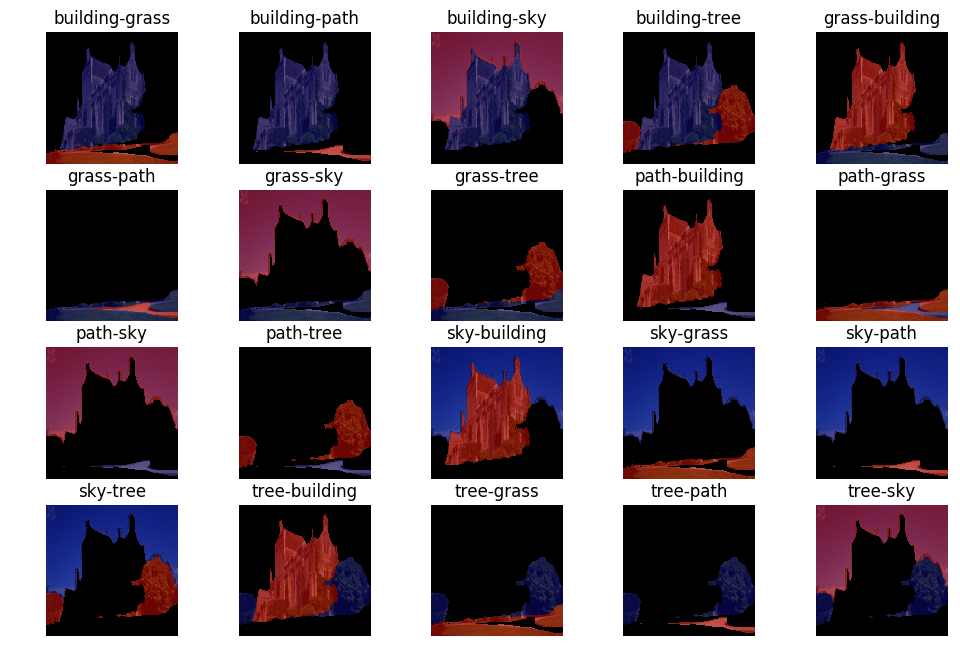

In [76]:
plt.figure(figsize=(12, 8))
for idx, (img, (n1, n2)) in enumerate(images):
    plt.subplot(4, 5, idx + 1)
    plt.axis('off')
    plt.title("{}-{}".format(net.color_palette.get_name(n1),
                             net.color_palette.get_name(n2)))
    plt.imshow(img[:, :, (2, 1, 0)])

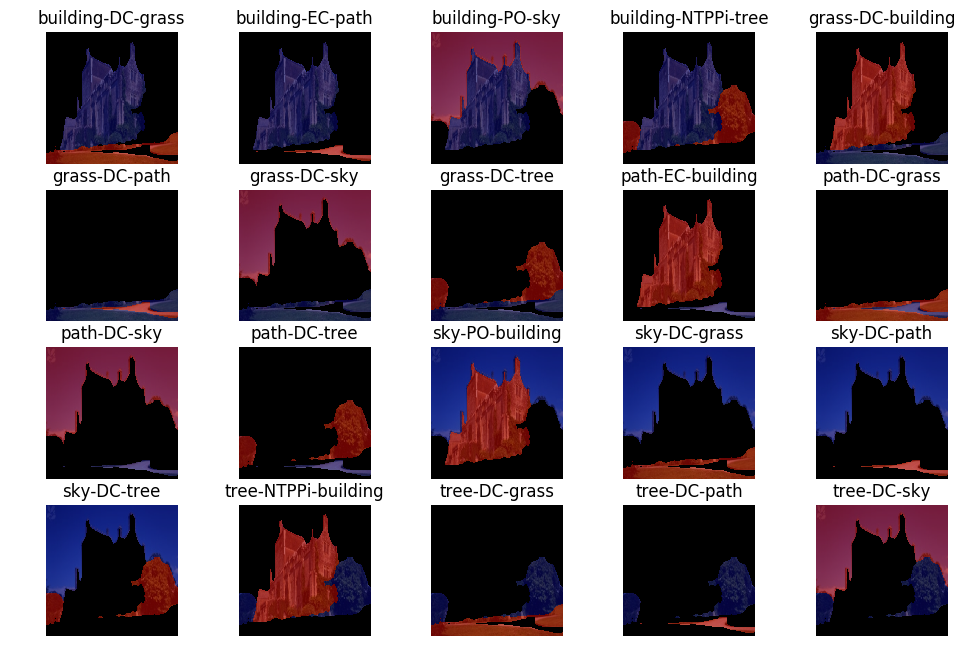

In [94]:
plt.figure(figsize=(12, 8))
for idx, (img, (n1, n2)) in enumerate(images):
    plt.subplot(4, 5, idx + 1)
    plt.axis('off')
    plt.title("{}-{}-{}".format(net.color_palette.get_name(n1),
                                topology[idx],
                                net.color_palette.get_name(n2)))
    plt.imshow(img[:, :, (2, 1, 0)])

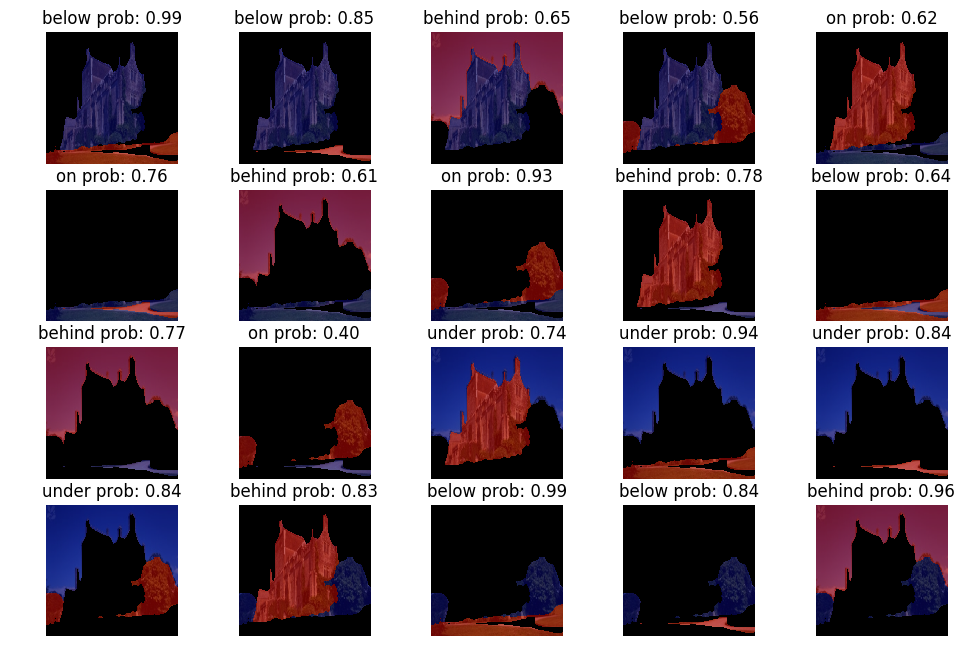

In [74]:
plt.figure(figsize=(12, 8))
for (idx, (img, (n1, n2))) in enumerate(images):
    plt.subplot(4, 5, idx + 1)
    plt.axis('off')
    plt.title("{} prob: {:.2f}".format(prepositions[idx], scores[idx]))
    plt.imshow(img[:, :, (2, 1, 0)])